<a href="https://colab.research.google.com/github/panashematsaudza/Time-Series-Forecasting-with-LSTM/blob/master/Time_Series_Forecasting_with_LSTMs_for_Daily_Coronavirus_Cases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch 
import os 
import numpy as np
import pandas as pd
from tqdm import tqdm 
import seaborn as sns 
from pylab import rcParams
import matplotlib.pyplot as plt 
from matplotlib import rc 
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F0210FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


We’re going to take the Time Series data only for confirmed cases (number of deaths and recovered cases are also available)

In [4]:
!gdown --id 1AsfdLrGESCQnRW5rbMz56A1KBc3Fe5aV

Downloading...
From: https://drive.google.com/uc?id=1AsfdLrGESCQnRW5rbMz56A1KBc3Fe5aV
To: /content/time_series_19-covid-Confirmed.csv
100% 19.2k/19.2k [00:00<00:00, 32.3MB/s]


# Data exploration

In [0]:
df = pd.read_csv('time_series_19-covid-Confirmed.csv')

In [6]:
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20
0,Anhui,Mainland China,31.8257,117.2264,1,9,15,39,60,70,106,152,200,237,297,340,408,480,530,591,665,733,779,830,860,889,910,934,950,962,973,982,986,987,988,989,989,989,989,989,989,990,990,990,990
1,Beijing,Mainland China,40.1824,116.4142,14,22,36,41,68,80,91,111,114,139,168,191,212,228,253,274,297,315,326,337,342,352,366,372,375,380,381,387,393,395,396,399,399,399,400,400,410,410,411,413,414
2,Chongqing,Mainland China,30.0572,107.8740,6,9,27,57,75,110,132,147,182,211,247,300,337,366,389,411,426,428,468,486,505,518,529,537,544,551,553,555,560,567,572,573,575,576,576,576,576,576,576,576,576
3,Fujian,Mainland China,26.0789,117.9874,1,5,10,18,35,59,80,84,101,120,144,159,179,194,205,215,224,239,250,261,267,272,279,281,285,287,290,292,293,293,293,293,293,293,294,294,296,296,296,296,296
4,Gansu,Mainland China,36.0611,103.8343,0,2,2,4,7,14,19,24,26,29,40,51,55,57,62,62,67,79,83,83,86,87,90,90,90,90,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91


In [0]:
#Let’s start by getting rid of the first four columns:
df = df.iloc[:,4:]

In [8]:
df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20
0,1,9,15,39,60,70,106,152,200,237,297,340,408,480,530,591,665,733,779,830,860,889,910,934,950,962,973,982,986,987,988,989,989,989,989,989,989,990,990,990,990
1,14,22,36,41,68,80,91,111,114,139,168,191,212,228,253,274,297,315,326,337,342,352,366,372,375,380,381,387,393,395,396,399,399,399,400,400,410,410,411,413,414
2,6,9,27,57,75,110,132,147,182,211,247,300,337,366,389,411,426,428,468,486,505,518,529,537,544,551,553,555,560,567,572,573,575,576,576,576,576,576,576,576,576
3,1,5,10,18,35,59,80,84,101,120,144,159,179,194,205,215,224,239,250,261,267,272,279,281,285,287,290,292,293,293,293,293,293,293,294,294,296,296,296,296,296
4,0,2,2,4,7,14,19,24,26,29,40,51,55,57,62,62,67,79,83,83,86,87,90,90,90,90,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91


In [9]:
#check missing values 
df.isnull().sum().sum()

0

In [0]:
daily_cases = df.sum(axis=0)
daily_cases.index =pd.to_datetime(daily_cases.index)


In [11]:
daily_cases.head()

2020-01-22     555
2020-01-23     653
2020-01-24     941
2020-01-25    1434
2020-01-26    2118
dtype: int64

Text(0.5, 1.0, 'Cumulative Daily Cases')

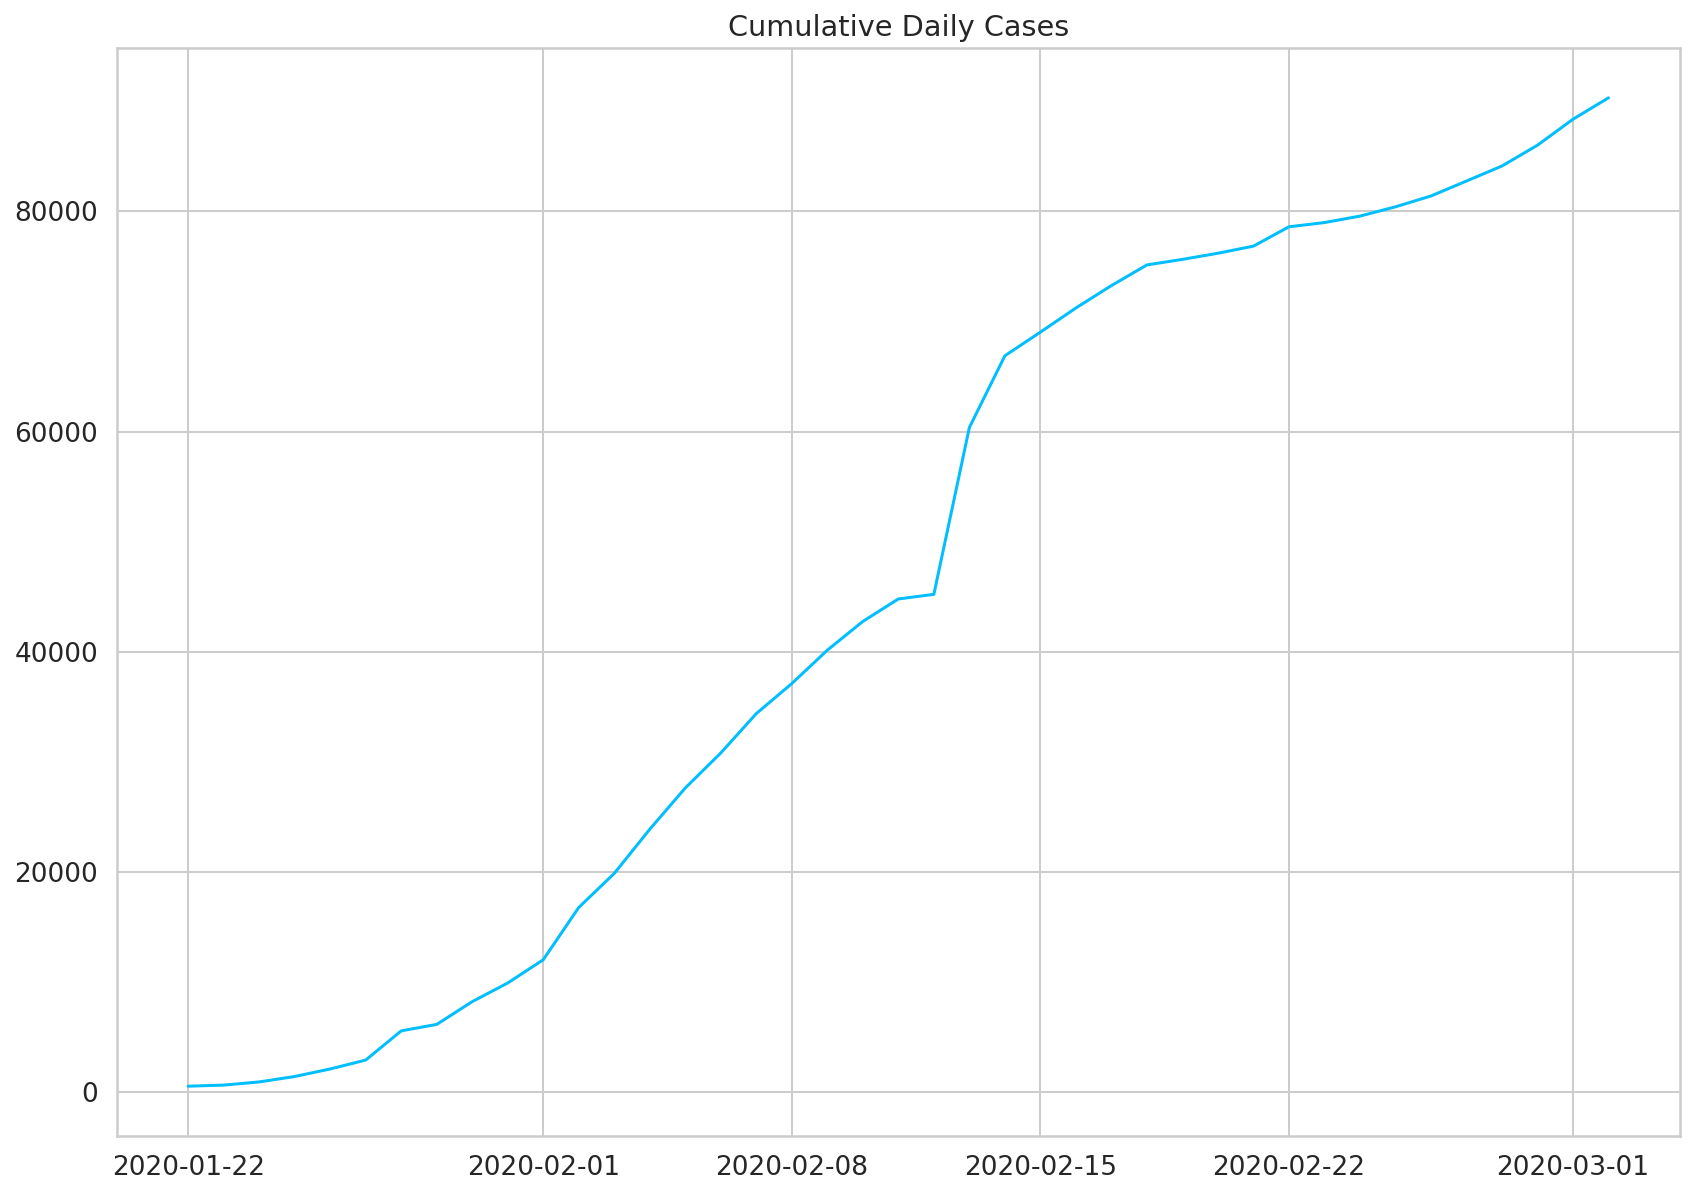

In [12]:
plt.plot(daily_cases)
plt.title("Cumulative Daily Cases")

In [0]:
daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)

In [14]:
daily_cases.head()

2020-01-22    555
2020-01-23     98
2020-01-24    288
2020-01-25    493
2020-01-26    684
dtype: int64

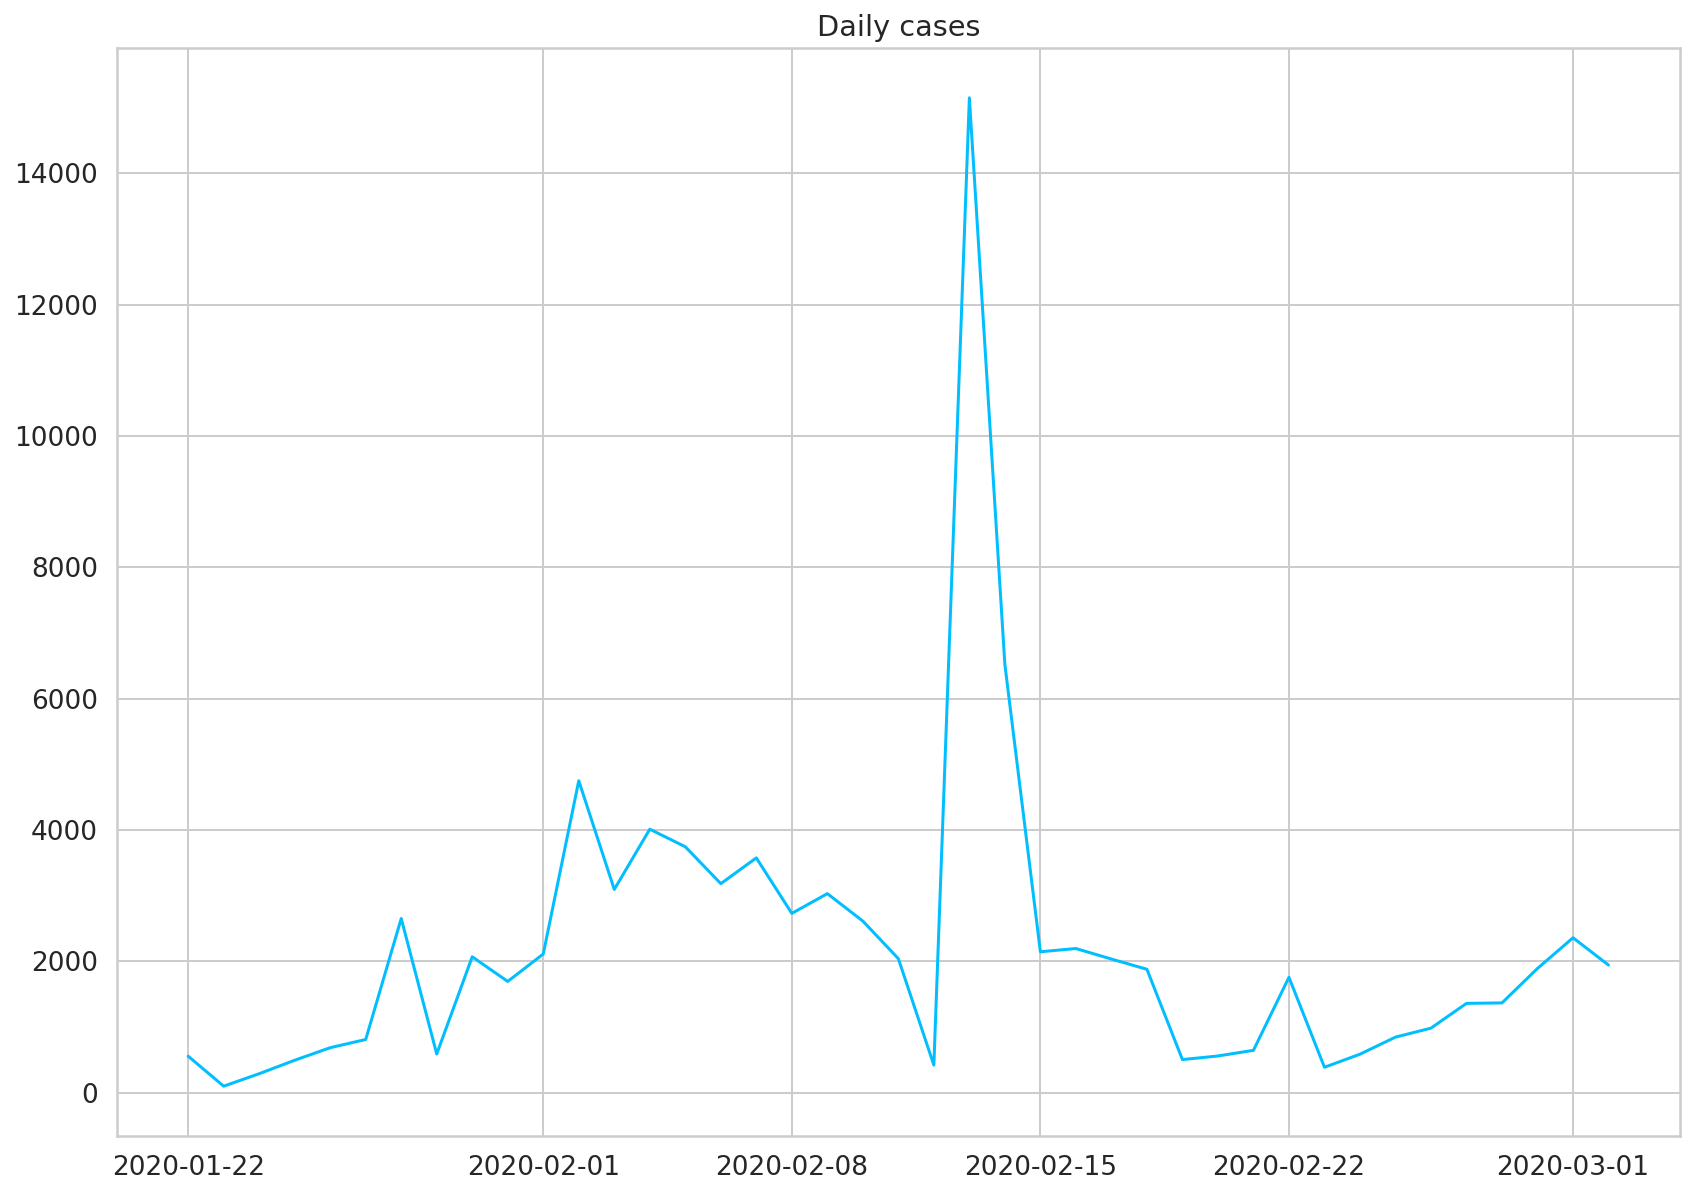

In [15]:
plt.plot(daily_cases)
plt.title("Daily cases");

In [38]:
daily_cases.shape

(41,)

# Preprocessing

In [0]:
test_data_size = 14 

In [0]:
train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]


In [41]:
train_data.shape

(27,)

In [0]:
#We have to scale the data (values will be between 0 and 1) if we want to increase the training speed

In [0]:
scaler = MinMaxScaler()
scaler = scaler.fit(np.expand_dims(train_data,axis=1))
train_data = scaler.transform(np.expand_dims(train_data,axis=1))
test_data  = scaler.transform(np.expand_dims(test_data,axis=1))

In [0]:
def create_sequences(data,seq_length):
  xs = []
  ys = []

  for i in range(len(data)-seq_length-1):
    x = data[i:(i+seq_length)]
    y = data[i+seq_length]
    xs.append(x)
    ys.append(y)

    return np.array(xs) ,np.array(ys)

In [0]:
seq_length = 5
X_train,y_train = create_sequences(train_data,seq_length)
X_test,y_test = create_sequences(test_data,seq_length)
X_train =torch.from_numpy(X_train).float()
y_train =torch.from_numpy(y_train).float()
X_test =torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [46]:
X_train.shape

torch.Size([1, 5, 1])

In [47]:
X_train[:2]

tensor([[[0.0304],
         [0.0000],
         [0.0126],
         [0.0262],
         [0.0389]]])

In [48]:
y_train.shape

torch.Size([1, 1])

In [49]:
y_train[:2]

tensor([[0.0472]])

In [0]:
class CoronaVirusPredictor(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

# Training

In [0]:
def train_model(
  model, 
  train_data, 
  train_labels, 
  test_data=None, 
  test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = 60

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    
    optimiser.zero_grad()

    loss.backward()

    optimiser.step()
  
  return model.eval(), train_hist, test_hist

In [0]:
model = CoronaVirusPredictor(
    n_features=1,
    n_hidden=512,
    seq_len=seq_length,
    n_layers =2 
)

In [60]:
model,train_hist,test_hist =train_model(model,X_train,y_train,X_test,y_test)

Epoch 0 train loss: 0.0003742028202395886 test loss: 0.00015340177924372256
Epoch 10 train loss: 1.225320556841325e-05 test loss: 0.0012663964880630374
Epoch 20 train loss: 1.0179729770243284e-06 test loss: 0.0015653087757527828
Epoch 30 train loss: 9.025222425407264e-06 test loss: 0.0010263362200930715
Epoch 40 train loss: 2.7235019572913188e-08 test loss: 0.001780848135240376
Epoch 50 train loss: 2.0182269508950412e-06 test loss: 0.002069240901619196


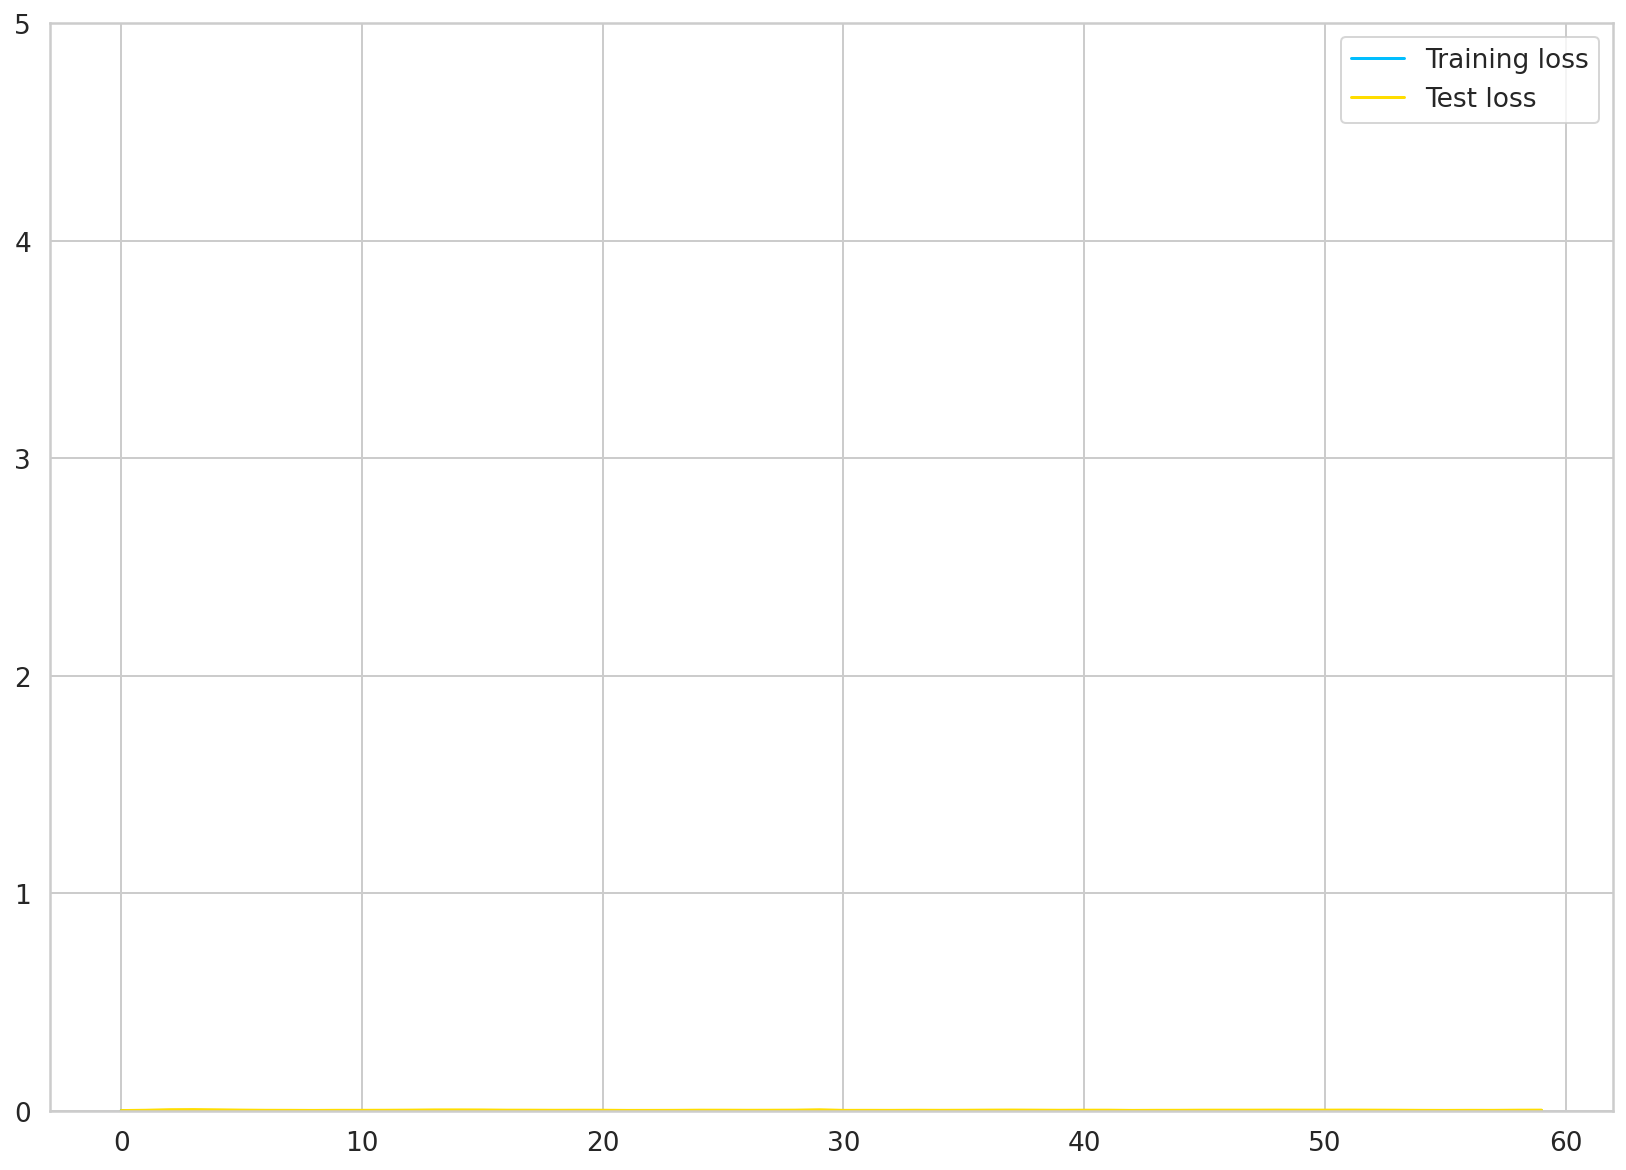

In [61]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 5))
plt.legend();

In [0]:
with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [0]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

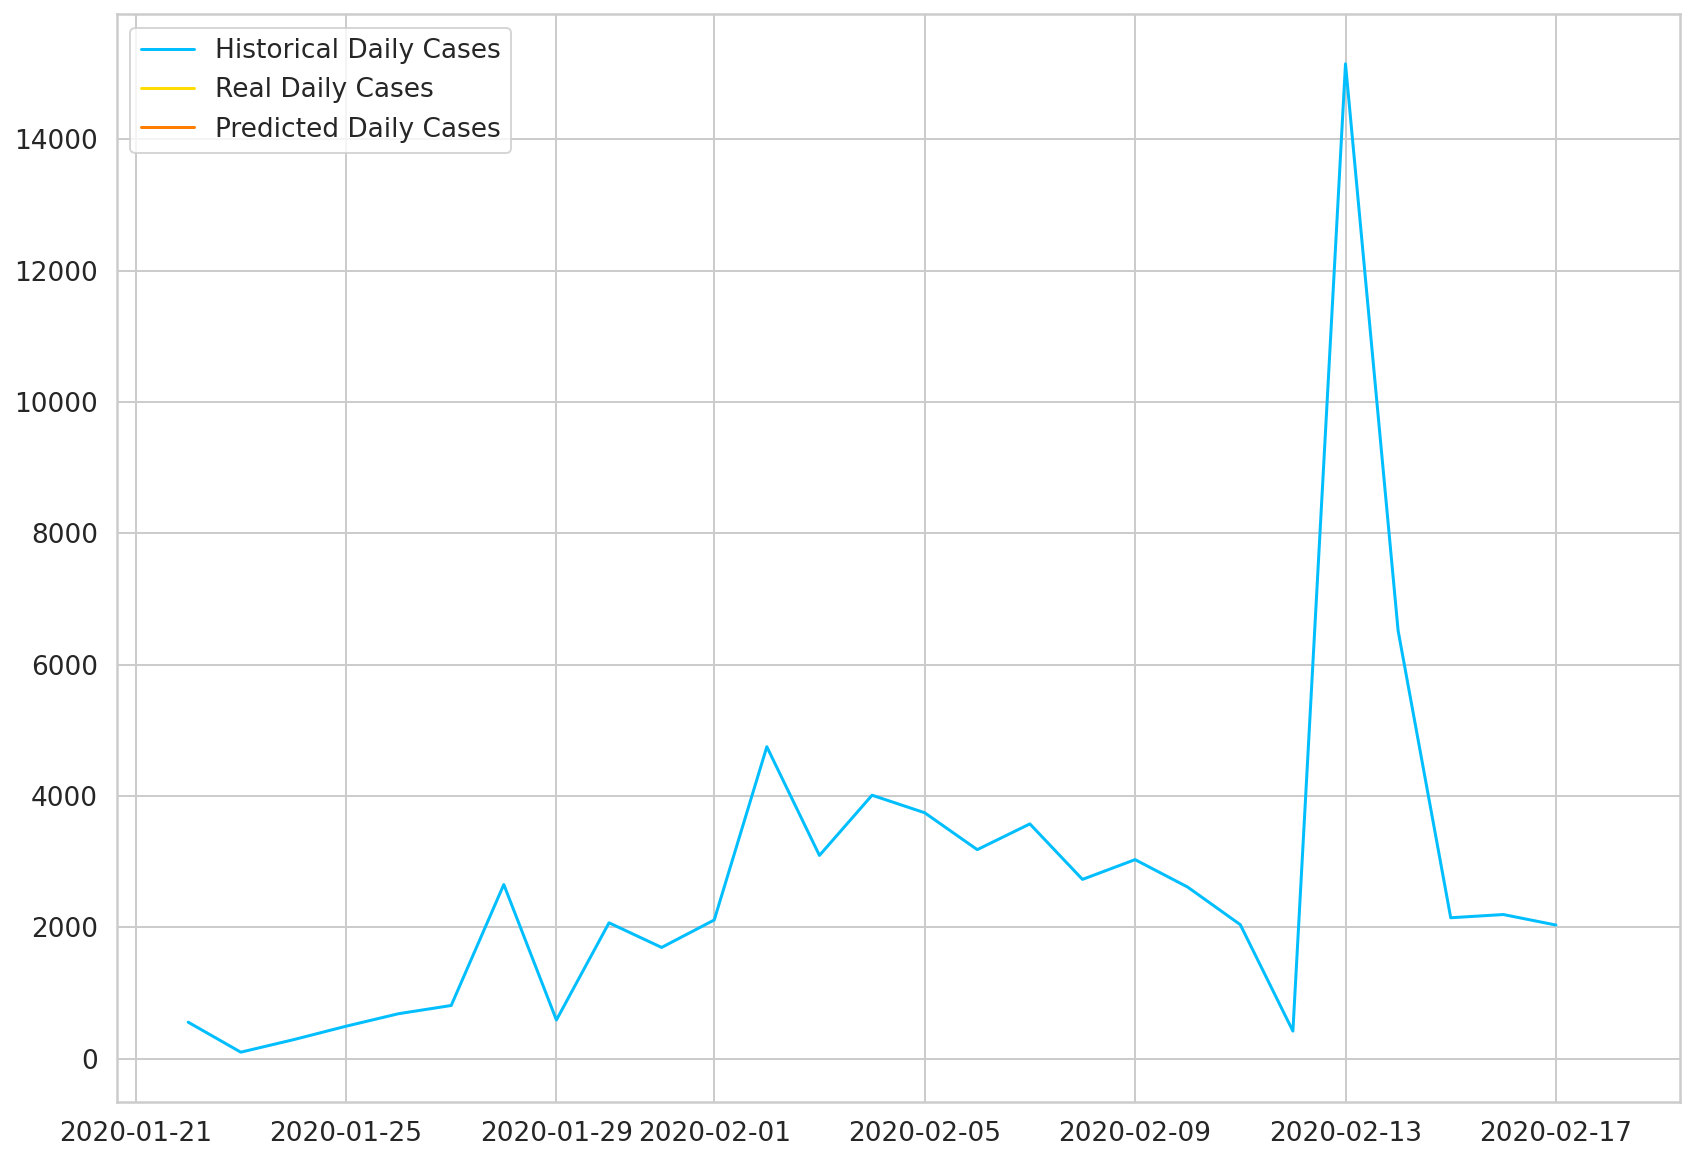

In [64]:
plt.plot(
  daily_cases.index[:len(train_data)], 
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  true_cases,
  label='Real Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  predicted_cases, 
  label='Predicted Daily Cases'
)

plt.legend();

In [65]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(daily_cases, axis=1))

all_data = scaler.transform(np.expand_dims(daily_cases, axis=1))

all_data.shape

(41, 1)

In [66]:
X_all, y_all = create_sequences(all_data, seq_length)

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, _ = train_model(model, X_all, y_all)

Epoch 0 train loss: 0.003927942365407944
Epoch 10 train loss: 0.00036259705666452646
Epoch 20 train loss: 0.00012497129500843585
Epoch 30 train loss: 2.1833695427631028e-05
Epoch 40 train loss: 2.5609881049604155e-05
Epoch 50 train loss: 4.094589166925289e-05


#Predict Future Cases

In [0]:
DAYS_TO_PREDICT = 12

with torch.no_grad():
  test_seq = X_all[:1]
  preds = []
  for _ in range(DAYS_TO_PREDICT):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [0]:
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [69]:
daily_cases.index[-1]

Timestamp('2020-03-02 00:00:00')

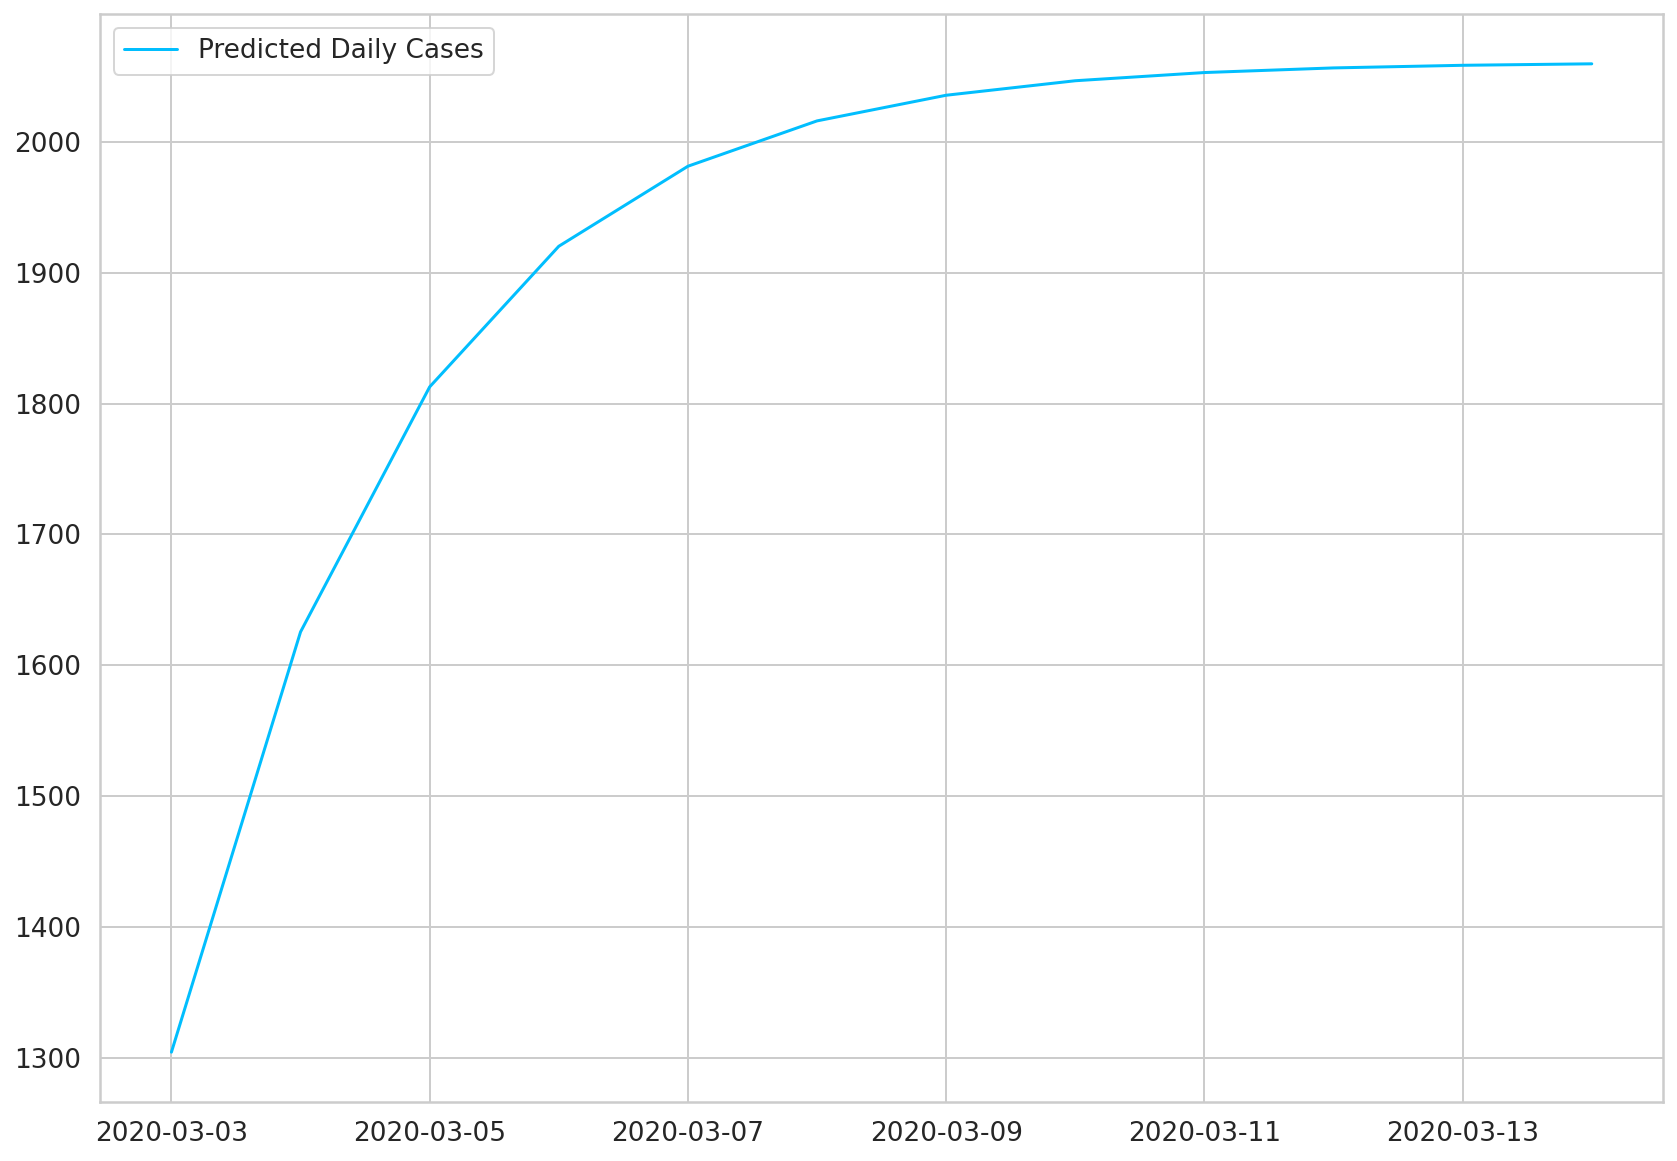

In [70]:
predicted_index = pd.date_range(
  start=daily_cases.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

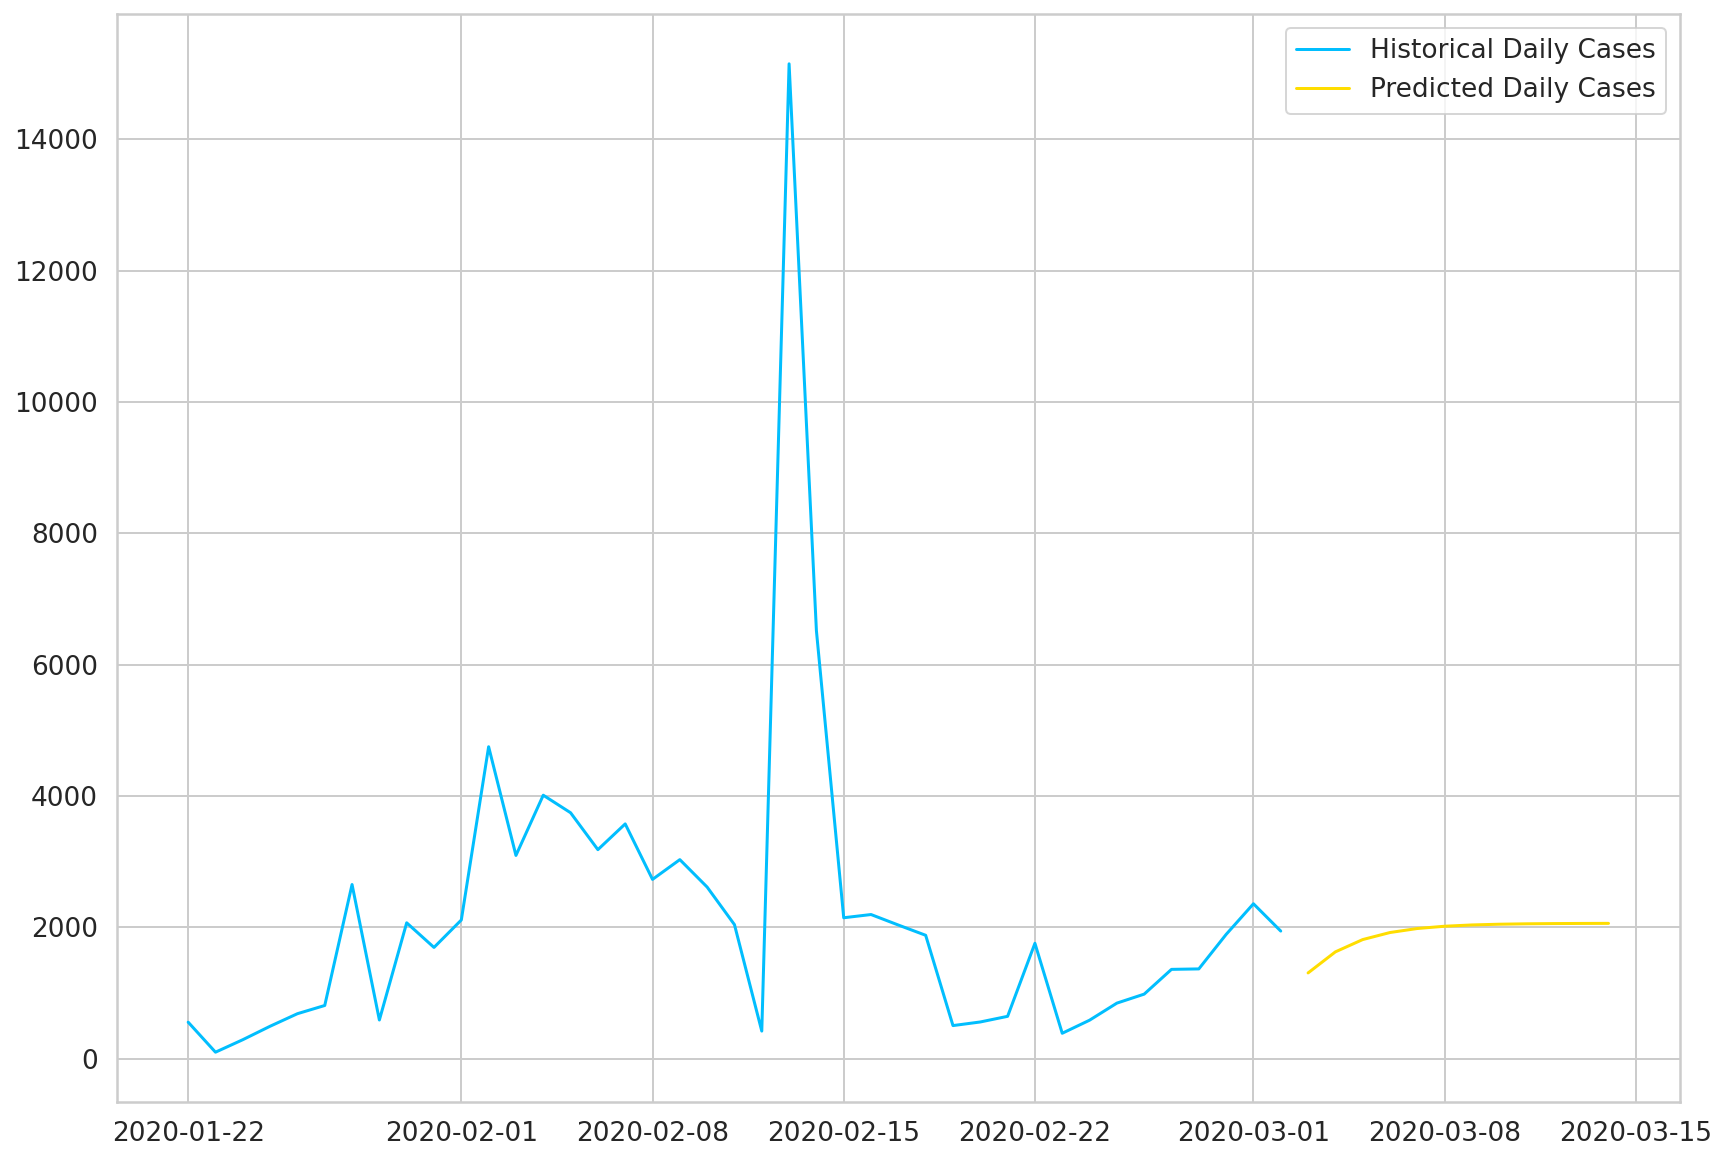

In [71]:
plt.plot(daily_cases, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();